In [43]:
import arviz as az

from tms_risk.cogmodels.fit_model import get_data, build_model
from tms_risk.cogmodels.utils import cluster_offers, plot_prediction, summarize_ppc

from bauer.utils.math import softplus_np, inverse_softplus_np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os.path as op


bids_folder = '/data/ds-tmsrisk'

model_label = 'session1_tms'
idata = az.from_netcdf(f'/data/ds-tmsrisk/derivatives/cogmodels/model-{model_label}_trace.netcdf')

data = get_data(bids_folder, model_label=model_label)
data['log(risky/safe)'] = data.groupby(['subject'],
                                group_keys=False).apply(cluster_offers)

model = build_model(model_label, data)
model.build_estimation_model()
ppc = {}
ppc['baseline'] = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=data)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
Sampling: [ll_bernoulli]


In [44]:
model_keys = ['n1_evidence_sd', 'n2_evidence_sd', 'both', 'risky_prior_mu', 'both + risky_prior_mu', 'n1_evidence_sd + risky_prior_mu', 'n2_evidence_sd + risky_prior_mu'] 

In [45]:
for key in model_keys:
    print(key)
    idata2 =idata.copy()

    if key in ['n1_evidence_sd', 'n2_evidence_sd']:
        idata2.posterior[key] = idata2.posterior[key] * 1.25
    elif key in ['risky_prior_mu']:
        idata2.posterior[key] = idata2.posterior[key] * 1.1
    elif key == 'both':
        idata2.posterior['n1_evidence_sd'] = idata2.posterior['n1_evidence_sd'] * 1.25
        idata2.posterior['n2_evidence_sd'] = idata2.posterior['n2_evidence_sd'] * 1.25
    elif key == 'n1_evidence_sd + risky_prior_mu':
        idata2.posterior['n1_evidence_sd'] = idata2.posterior['n1_evidence_sd'] * 1.25
        idata2.posterior['risky_prior_mu'] = idata2.posterior['risky_prior_mu'] * 1.1
    elif key == 'n2_evidence_sd + risky_prior_mu':
        idata2.posterior['n2_evidence_sd'] = idata2.posterior['n2_evidence_sd'] * 1.25
        idata2.posterior['risky_prior_mu'] = idata2.posterior['risky_prior_mu'] * 1.1
    elif key == 'both + risky_prior_mu':
        idata2.posterior['n1_evidence_sd'] = idata2.posterior['n1_evidence_sd'] * 1.25
        idata2.posterior['n2_evidence_sd'] = idata2.posterior['n2_evidence_sd'] * 1.25
        idata2.posterior['risky_prior_mu'] = idata2.posterior['risky_prior_mu'] * 1.1

    for key_ in ['n1_evidence_sd', 'n2_evidence_sd']:
        idata2.posterior[f'{key_}_untransformed'] = inverse_softplus_np(idata2.posterior[key_])

    ppc[key] = model.ppc(trace=idata2.sel(draw=slice(None, None, 10)), data=data)

n1_evidence_sd


Sampling: [ll_bernoulli]


n2_evidence_sd


Sampling: [ll_bernoulli]


both


Sampling: [ll_bernoulli]


risky_prior_mu


Sampling: [ll_bernoulli]


both + risky_prior_mu


Sampling: [ll_bernoulli]


n1_evidence_sd + risky_prior_mu


Sampling: [ll_bernoulli]


n2_evidence_sd + risky_prior_mu


Sampling: [ll_bernoulli]


In [46]:
ppc = pd.concat(ppc.values(), keys=ppc.keys(), names=['condition']).xs('ll_bernoulli', 0, 'variable')
ppc

chain                                                                                                                                                                                                               0  \
draw                                                                                                                                                                                                              0     
condition                       subject run trial_nr session stimulation_condition rt       n1    n2   p1   p2   choice risky_first chose_risky n_risky n_safe frac     log(risky/safe) log(n1)  bin(risky/safe)        
baseline                        1       1   1        1       baseline              1.568772 28.0  86.0 1.00 0.55 True   False       True        86.0    28.0   3.071429 1.0740          3.332205 80%              1.0   
                                            2        1       baseline              1.191652 7.0   21.0 1.00 0.55 True   False       True        21.0    7.0    3.000000 1.0740          1.945910 80%              1.0   
                                            3        1       baseline              0.747337 7.0   21.0 1.00 0.55 True   False       True        21.0    7.0    3.000000 1.0740          1.945910 80%              1.0   
                                            4        1       baseline              1.611574 10.0  24.0 1.00 0.55 False  False       False       24.0    10.0   2.400000 0.8835          2.302585 44%              1.0   
                                            5        1       baseline              1.318757 20.0  44.0 1.00 0.55 True   False       True        44.0    20.0   2.200000 0.7840          2.995732 44%              0.0   
...                                                                                                                                                                                                               ...   
n2_evidence_sd + risky_prior_mu 74      6   116      1       baseline              0.722341 27.0  7.0  0.55 1.00 False  True        True        27.0    7.0    3.857143 1.2685          3.295837 80%              0.0   
                                            117      1       baseline              0.755906 30.0  10.0 0.55 1.00 False  True        True        30.0    10.0   3.000000 1.0550          3.401197 68%              1.0   
                                            118      1       baseline              0.655722 111.0 28.0 0.55 1.00 False  True        True        111.0   28.0   3.964286 1.2685          4.709530 80%              0.0   
                                            119      1       baseline              0.555629 15.0  14.0 0.55 1.00 True   True        False       15.0    14.0   1.071429 0.1480          2.708050 20%              1.0   
                                            120      1       baseline              0.772343 24.0  10.0 0.55 1.00 False  True        True        24.0    10.0   2.400000 0.8365          3.178054 56%              0.0   

chain                                                                                                                                                                                                                  \
draw                                                                                                                                                                                                              10    
condition                       subject run trial_nr session stimulation_condition rt       n1    n2   p1   p2   choice risky_first chose_risky n_risky n_safe frac     log(risky/safe) log(n1)  bin(risky/safe)        
baseline                        1       1   1        1       baseline              1.568772 28.0  86.0 1.00 0.55 True   False       True        86.0    28.0   3.071429 1.0740          3.332205 80%              1.0   
                                            2        1       baseline              1.191652 7

In [47]:
df = data.copy()
df['log(risky/safe)'] = df['bin(risky/safe)']
ppc.loc[ppc.index.get_level_values('risky_first')] = 1 - ppc.loc[ppc.index.get_level_values('risky_first')]
ppc = ppc.reset_index('log(risky/safe)')
ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')

In [48]:
groupby = ['n_safe', 'risky_first', 'condition']
ppc_combined = ppc.groupby(['subject']+groupby).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_73619/350894087.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc_combined = ppc.groupby(['subject']+groupby).mean()


In [49]:
ppc_summary = summarize_ppc(ppc_combined, groupby=groupby)
p = df.groupby(groupby[:-1])[['chose_risky']].mean()
ppc_summary = ppc_summary.join(p).reset_index()
ppc_summary = ppc_summary.groupby(groupby).mean()

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


In [50]:
ppc_summary['Order'] = ppc_summary.index.get_level_values('risky_first').to_series(ppc_summary.index).map({False:'Safe first', True:'Risky first'})

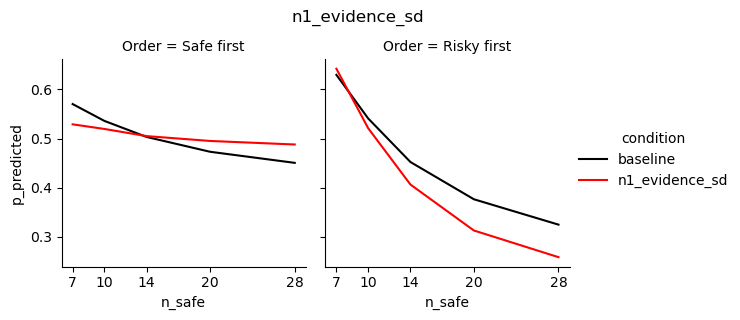

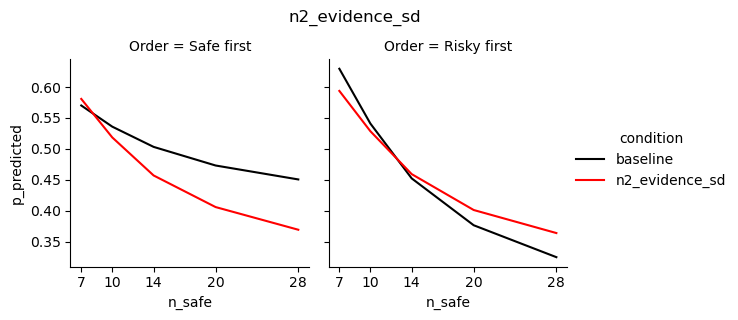

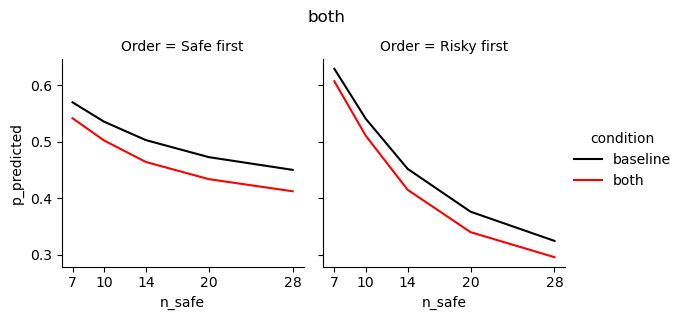

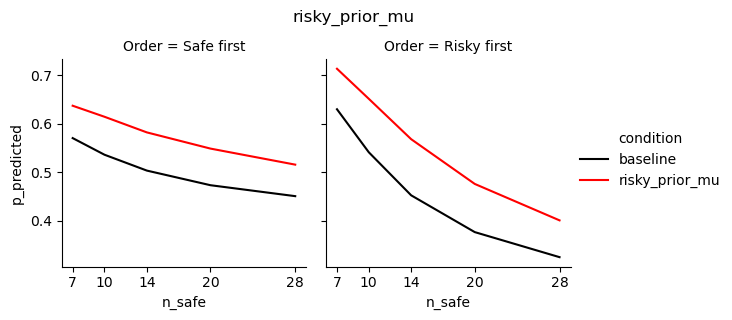

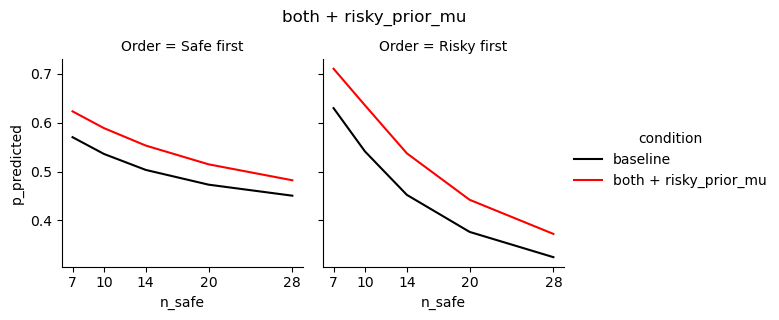

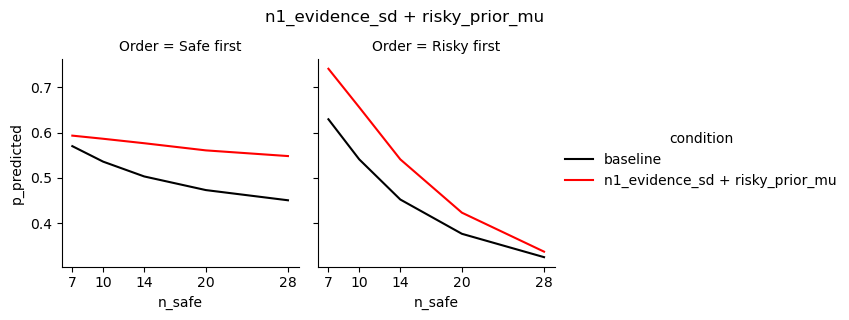

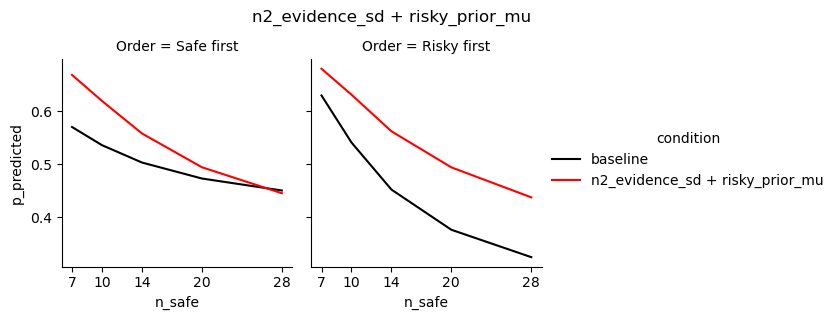

In [51]:
for model in model_keys:
    d = ppc_summary.loc[(slice(None), slice(None), ['baseline', model]), :]

    g = sns.FacetGrid(d.reset_index(), hue='condition', col='Order', palette=['k', 'r'])
    g.map(plt.plot, 'n_safe', 'p_predicted')
    g.fig.suptitle(model, y=1.05)
    g.set(xticks=[7.0, 10.0, 14.0, 20.0, 28.0])

    g.add_legend()


    g.savefig(op.join(bids_folder, 'derivatives', 'cogmodels', f'simulation_change_{model.replace(" ", "_")}.pdf')) 

In [52]:
groupby = ['log(risky/safe)', 'risky_first', 'condition']
ppc_combined = ppc.groupby(['subject']+groupby).mean()
ppc_summary = summarize_ppc(ppc_combined, groupby=groupby)
p = df.groupby(groupby[:-1])[['chose_risky']].mean()
ppc_summary = ppc_summary.join(p).reset_index()
ppc_summary = ppc_summary.groupby(groupby).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_73619/3552195614.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc_combined = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


In [53]:
for model in model_keys:
    d = ppc_summary.loc[(slice(None), slice(None), ['baseline', model]), :]

    g = sns.FacetGrid(d.reset_index(), hue='condition', col='Order', palette=['k', 'r'])
    g.map(plt.plot, 'log(risky/safe)', 'p_predicted')
    g.fig.suptitle(model, y=1.05)

    g.add_legend()

KeyError: 'Order'